In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torchvision
from torchvision import models as mods
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA
from sklearn.covariance import LedoitWolf, MinCovDet

from torchvision.transforms import transforms

from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.random_projection import SparseRandomProjection

import torch
import torch.nn as nn

from data.mvtec import *
inv_norm = MVTEC().inv_normalize

from hugeica import *
from models.backbones import *

np.random.seed(252525)
torch.manual_seed(252525)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
MVTEC.CLASSES

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['bottle',
 'carpet',
 'leather',
 'pill',
 'tile',
 'wood',
 'cable',
 'grid',
 'toothbrush',
 'zipper',
 'capsule',
 'hazelnut',
 'metal_nut',
 'screw',
 'transistor']

# Data

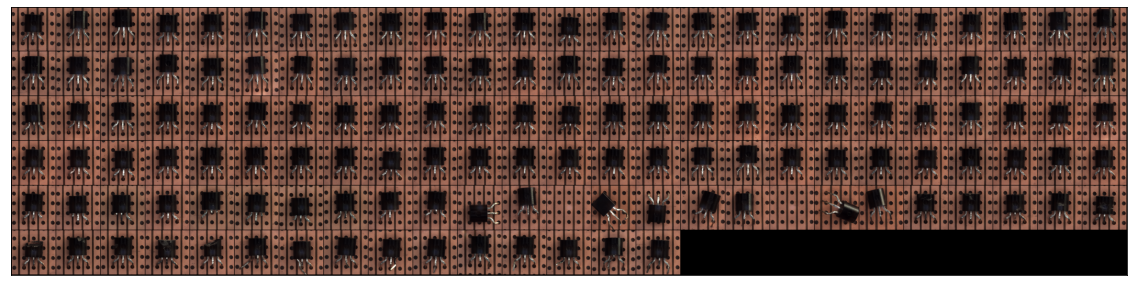

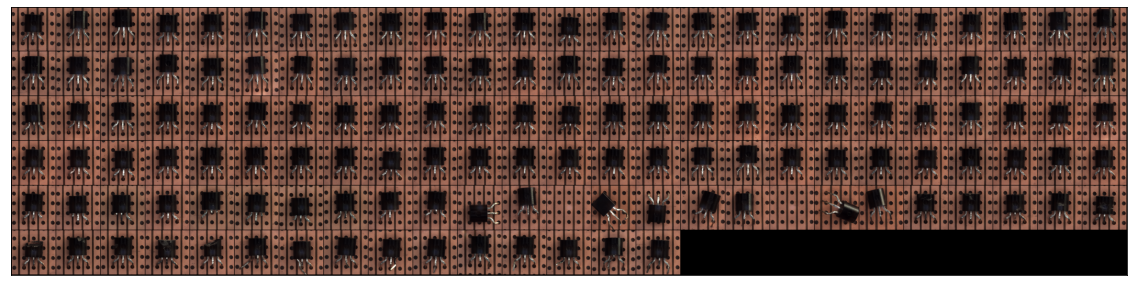

((213, 3, 232, 232), (60, 3, 232, 232), (40, 3, 232, 232))

In [126]:
clazz = 14
X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=232, s=64, label_per_patch=True, augment=False, load_size=232, crop_size=232, normalize=False)

plt.rcParams["figure.figsize"] = (20, 20)
show( torchvision.utils.make_grid(torch.cat( [ torch.from_numpy( X_[:50]), 
                                              torch.from_numpy( X_valid_[:50]), 
                                              torch.from_numpy( X_test_[:50])] ), 
                                  nrow=25, normalize=True,  value_range=(X_.min(),  X_.max()), scale_each=True , padding=3 ))
plt.show()

s =  X_.std()

#X_ = X_ - flatten(X_).mean(1)[:, None, None, None]
#X_ = X_ / np.linalg.norm(flatten(X_), axis=1)[:, None, None, None]

#X_valid_ = X_valid_ - flatten(X_valid_).mean(1)[:, None, None, None]
#X_valid_ = X_valid_ / np.linalg.norm(flatten(X_valid_), axis=1)[:, None, None, None]
#X_valid_ = X_valid_ /  X_.std() * s

#X_test_ = X_test_ - flatten(X_test_).mean(1)[:, None, None, None]
#X_test_ = X_test_ / np.linalg.norm(flatten(X_test_), axis=1)[:, None, None, None]
#X_test_ = X_test_ /  X_.std() * s

#X_ = X_ / X_.std() * s


X_.mean(), X_.std()

plt.rcParams["figure.figsize"] = (20, 20)
show( torchvision.utils.make_grid(torch.cat( [ torch.from_numpy( X_[:50]), 
                                              torch.from_numpy( X_valid_[:50]), 
                                              torch.from_numpy( X_test_[:])] ), 
                                  nrow=25, normalize=True,  value_range=(X_.min(),  X_.max()), scale_each=True , padding=3 ))
plt.show()

X_.shape, X_valid_.shape, X_test_.shape


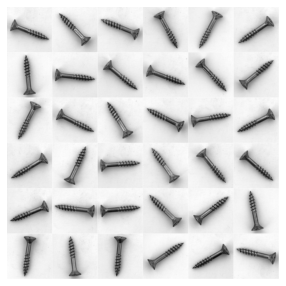

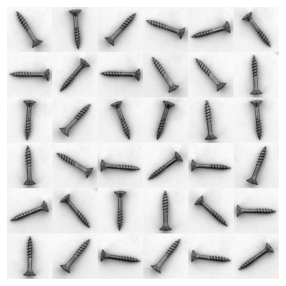

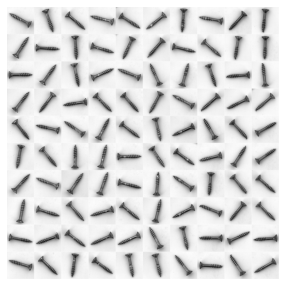

(119, 3, 232, 232)

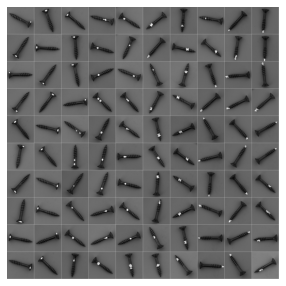

In [21]:
plt.rcParams["figure.figsize"] = (5, 5)
show_filters_color(X_[:36].reshape(36, -1).T, C=3)
plt.show()
show_filters_color(X_valid_[:int(np.sqrt(len(X_valid_)))**2].reshape(int(np.sqrt(len(X_valid_)))**2, -1).T, C=3)
plt.show()
show_filters_color((X_test_)[:int(np.sqrt(len(X_test_)))**2].reshape(int(np.sqrt(len(X_test_)))**2, -1).T, C=3)
plt.show()
X_test_ +=  X_labels_
show_filters_color((X_test_)[:int(np.sqrt(len(X_test_)))**2].reshape(int(np.sqrt(len(X_test_)))**2, -1).T, C=3)
X_test_.shape

## SIFT alginment

In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
sift = cv2.SIFT_create()

#img1 = cv2.imread('data/teaser.PNG',0)[:200, :200]          # queryImage


kp1, des1 = sift.detectAndCompute(img1,None)

NameError: name 'img1' is not defined

In [ ]:
import numpy as np
import cv2

query_img = toImage(inv_norm( toTensor( toImage( X_[0] ) ) ) * 255).numpy().astype(np.uint8)
train_img = toImage(inv_norm( toTensor( toImage( X_valid_[0] ) ) ) * 255).numpy().astype(np.uint8)

query_img = query_img[:, :, 0]
train_img = train_img[:, :, 0]
  
# Initialize the ORB detector algorithm
orb = cv2.ORB_create(edgeThreshold=10, patchSize=20)
  
# Now detect the keypoints and compute
# the descriptors for the query image
# and train image
queryKeypoints, queryDescriptors = orb.detectAndCompute(query_img_bw,None)
trainKeypoints, trainDescriptors = orb.detectAndCompute(train_img_bw,None)
 
# Initialize the Matcher for matching
# the keypoints and then match the
# keypoints
matcher = cv2.BFMatcher()
matches = matcher.match(queryDescriptors,trainDescriptors)
matches = sorted(matches, key=lambda x: x.distance)
  
# draw the matches to the final image
# containing both the images the drawMatches()
# function takes both images and keypoints
# and outputs the matched query image with
# its train image
final_img = cv2.drawMatches(query_img, queryKeypoints,
train_img, trainKeypoints, matches[:20],None)
  
final_img = cv2.resize(final_img, (2*650,650))
 
# Show the final image
plt.imshow( final_img)
plt.show()

base_keypoints = np.float32([queryKeypoints[m.queryIdx].pt for m in matches[:number_of_matches]]).reshape(-1, 1, 2)
test_keypoints = np.float32([trainKeypoints[m.trainIdx].pt for m in matches[:number_of_matches]]).reshape(-1, 1, 2)

M, mask = cv2.findHomography(base_keypoints, test_keypoints, cv2.RANSAC, 20.0)

#M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
#matchesMask = mask.ravel().tolist()

#h,w = img1g.shape
#pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
#dst = cv2.perspectiveTransform(pts,M)

#img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

im_dst = cv2.warpPerspective(img2, M, img1.shape[:2])
plt.imshow(im_dst)
plt.show()

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
sift = cv2.SIFT()

def align_homography(template, images):
    MIN_MATCH_COUNT = 6

    img1 = toImage(inv_norm( toTensor( toImage( template ) ) ) * 255).numpy().astype(np.uint8)
    img2 = toImage(inv_norm( toTensor( toImage( images[0] ) ) ) * 255).numpy().astype(np.uint8)
    
    img1g = img1[:, :, 0]
    img2g = img2[:, :, 0]
    
    plt.imshow(img1g)
    plt.show()
    plt.imshow(img2g)
    plt.show()
    
    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1g, None)
    kp2, des2 = sift.detectAndCompute(img2g, None)
    #print(des2.shape, des1.shape)
    
    # Initiate ORB detector
    orb = cv2.ORB_create(edgeThreshold=15, patchSize=31, nlevels=8, fastThreshold=20, scaleFactor=1.2, WTA_K=2,scoreType=cv2.ORB_HARRIS_SCORE, firstLevel=0, nfeatures=500)
    
    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1g,None)
    kp2, des2 = orb.detectAndCompute(img2g,None)
    
    #print(des2.shape, des1.shape)
    
    #FLANN_INDEX_KDTREE = 0
    #index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    #search_params = dict(checks = 50)

    #flann = cv2.FlannBasedMatcher(index_params, search_params)

    #matches = flann.knnMatch(des1, des2, k=2)
    
    #matcher = cv2.BFMatcher()
    #matches = matcher.match(des1, des2)
    
    #final_img = cv2.drawMatches(img1, des1, img2, des2, matches[:20], None)
  
    #final_img = cv2.resize(final_img, (1000,650))
 
    # Show the final image
    #cv2.imshow("Matches", final_img)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        #matchesMask = mask.ravel().tolist()

        #h,w = img1g.shape
        #pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        #dst = cv2.perspectiveTransform(pts,M)

        #img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
        
        im_dst = cv2.warpPerspective(img2, M, img1.shape[:2])

    else:
        print("Not enough matches are found - %d/%d", (len(good),MIN_MATCH_COUNT))
        matchesMask = None
        
    return im_dst


X_valid_aligned = align_homography(X_[0], X_valid_[:10])

plt.imshow(X_valid_aligned)

## Rotation alignment

In [9]:
from skimage.transform import rotate, rescale
import torchvision.transforms.functional as TF

def align_rotation(template, images, crop_size=100, center_crop=224):
    
    template = toNumpy(toPIL(inv_norm(centerCrop(toTensor(toImage(template)), crop_size))))
    template = template - template.mean()
    template = template / np.linalg.norm(template)
    
    def find_angle(im):
        corr = []
        im = toImage(im)            
        for a in range(0, 2*360, 1):
            #im = toPIL(X_[1])
            #im = TF.rotate(im, 10)
            #im = rescale(im, 1, multichannel=True)
            im2 = rotate(im, a/2) 
            im2 = toNumpy(toPIL(inv_norm(centerCrop(toTensor(im2), crop_size))))
            im2 = im2 - im2.mean()
            im2 = im2 / np.linalg.norm(im2) 
            corr.append( np.mean(im2.flatten() * template.flatten()))    
        angle = np.abs(np.asarray(corr)).argmax()
        return angle / 2
    
    transformed_images = []
    for im in images:
        
        angle = find_angle(im)
        im = rotate(toImage(im), angle, mode="reflect")#, mode{‘constant’, ‘edge’, ‘symmetric’, ‘reflect’, ‘wrap’}, option)
        im = centerCrop(toTensor(im), center_crop).numpy()
        transformed_images.append(im)
        
    return np.stack(transformed_images)


X_aligned_ = align_rotation(X_[5], X_)
X_valid_aligned = align_rotation(X_[5], X_valid_)
X_test_aligned = align_rotation(X_[5], X_test_)

[autoreload of utils.patch_utils failed: Traceback (most recent call last):
  File "/home/matthias/.conda/envs/pytorch3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/matthias/.conda/envs/pytorch3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/matthias/.conda/envs/pytorch3/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/matthias/.conda/envs/pytorch3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in

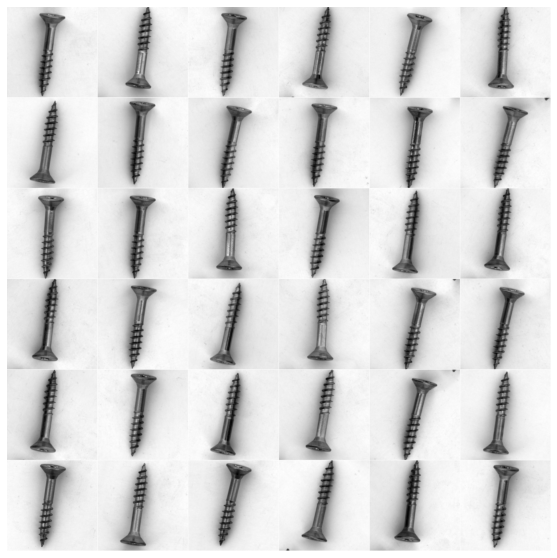

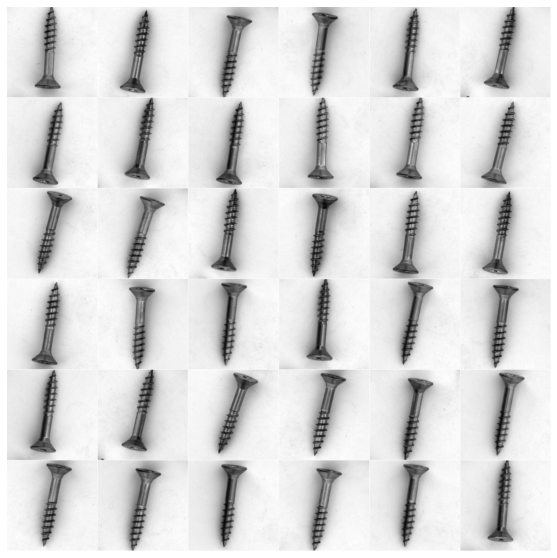

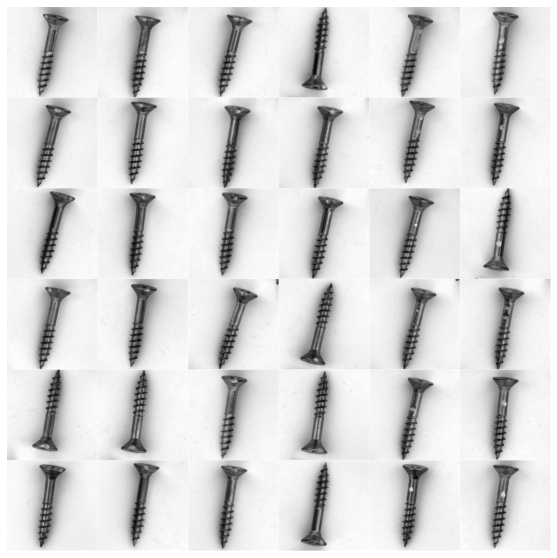

In [10]:
plt.rcParams["figure.figsize"] = (10, 10)
show_filters_color(X_aligned_[:36].reshape(36, -1).T, C=3)
plt.show()
show_filters_color(X_valid_aligned[:36].reshape(36, -1).T, C=3)
plt.show()
show_filters_color((X_test_aligned)[:36].reshape(36, -1).T, C=3)
plt.show()

In [ ]:
np.save("./data/screw_aligned_contrast_norm_X.npy", X_aligned_)
np.save("./data/screw_aligned_contrast_norm_X_in.npy", X_valid_aligned)
np.save("./data/screw_aligned_contrast_norm_X_out.npy", X_test_aligned)

In [51]:
np.save("./data/screw_aligned_no_norm_no_contr_X.npy", X_aligned_)
np.save("./data/screw_aligned_no_norm_no_contr_X_in.npy", X_valid_aligned)
np.save("./data/screw_aligned_no_norm_no_contr_X_out.npy", X_test_aligned)

## Augmentation

In [ ]:
X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz=13, P=8*28, s=28, label_per_patch=False, augment=False, size=224, normalize=False)

X_ = X_ - flatten(X_).mean(1)[:, None, None, None]
X_ = X_ / np.linalg.norm(flatten(X_), axis=1)[:, None, None, None]

X_valid_ = X_valid_ - flatten(X_valid_).mean(1)[:, None, None, None]
X_valid_ = X_valid_ / np.linalg.norm(flatten(X_valid_), axis=1)[:, None, None, None]

X_test_ = X_test_ - flatten(X_test_).mean(1)[:, None, None, None]
X_test_ = X_test_ / np.linalg.norm(flatten(X_test_), axis=1)[:, None, None, None]





In [ ]:
show( torchvision.utils.make_grid(torch.cat( [ torch.from_numpy( X_[:250]), 
                                              torch.from_numpy( X_valid_[:250]), 
                                              torch.from_numpy( X_test_[:250])] ), 
                                  nrow=30, normalize=False,  value_range=(X_.min(),  X_.max()), scale_each=False , padding=3 ))

In [ ]:
show( torchvision.utils.make_grid(torch.from_numpy( X_test_[:500]), nrow=25, normalize=False, value_range=(X_.min(),  X_.max()), scale_each=False , padding=3 ))

In [ ]:
show( torchvision.utils.make_grid(torch.from_numpy( X_[:500]), nrow=25, normalize=False, value_range=(X_.min(),  X_.max()), scale_each=False , padding=3 ))

# Anomaly Map

((320, 272, 14, 14), (119, 272, 14, 14), (41, 272, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=5000 is not a multiple of n_tiles=121. Setting bs=4961
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4352 must be less or equal to the batch number of samples 3993
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4147 must be less or equal to the batch number of samples 3993
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 121.70
n_clusters 387
n_clusters 387


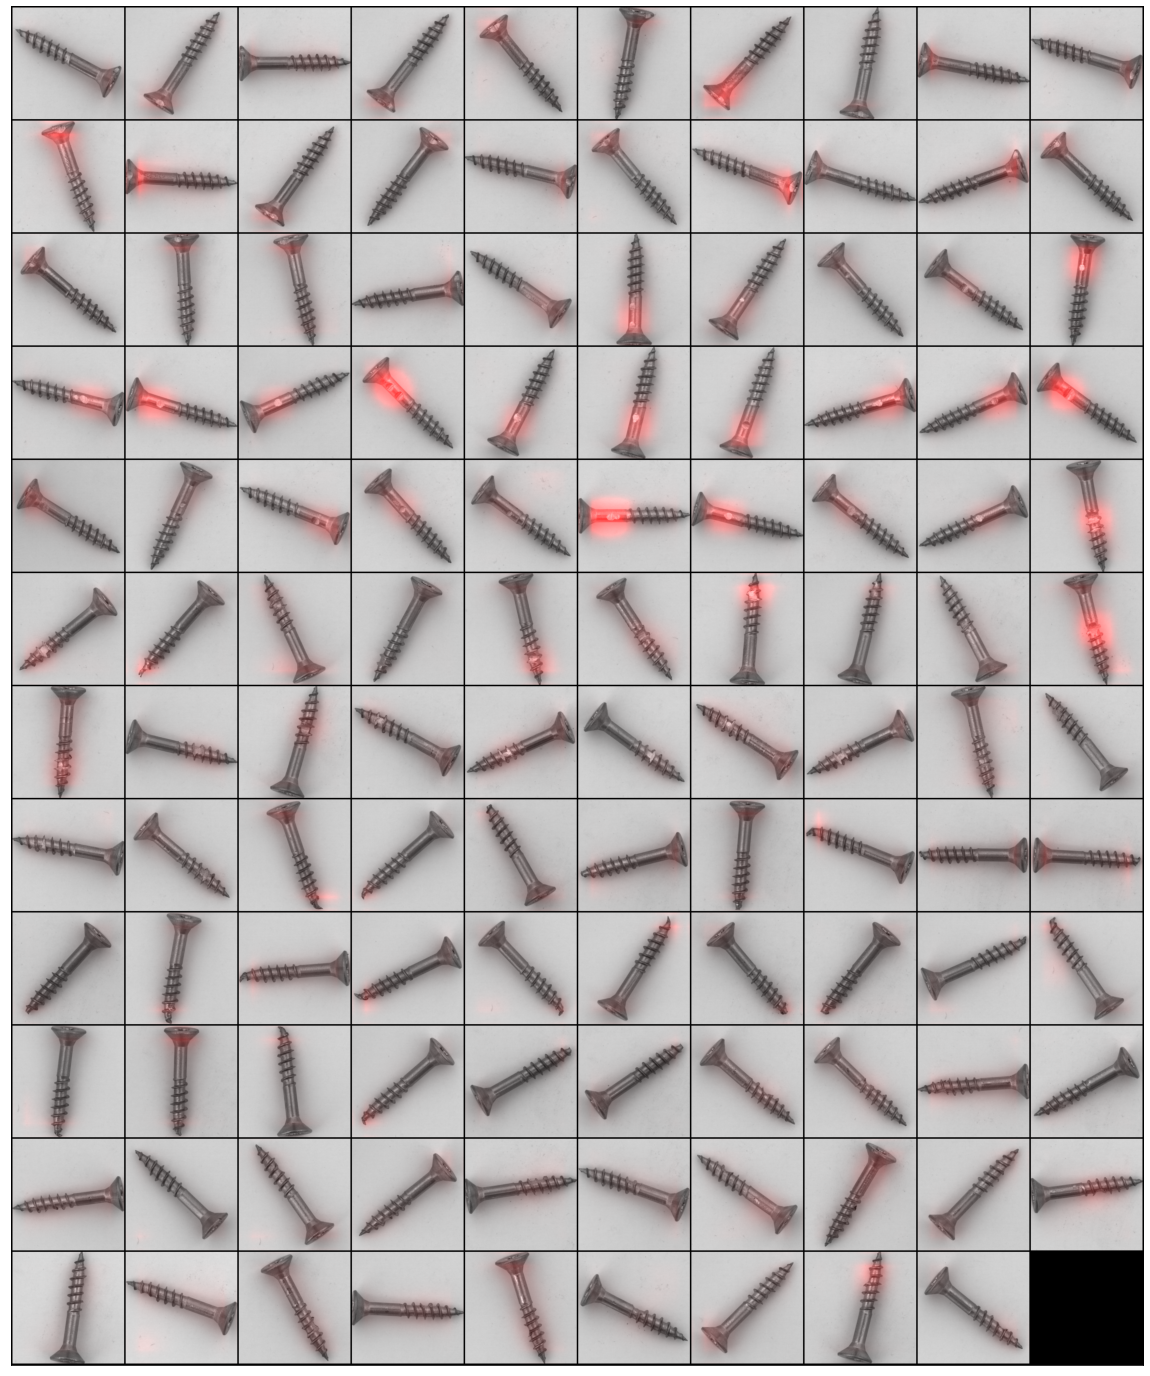

In [125]:
bs = 50
p = 4 # fallback patch_size
s = 1 # stride

net = mods.efficientnet_b4(pretrained=True).features
net = net.to(device)
net.eval()

for clazz in [13]:
    
    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False)

    X = concat_features(X_, net, layers=[5,6], fmap_pool=False)
    X_valid = concat_features(X_valid_, net, layers=[5,6], fmap_pool=False)
    X_test = concat_features(X_test_, net, layers=[5,6], fmap_pool=False)

    shapes = (X.shape, X_test.shape, X_valid.shape)
    c = X.shape[1]
    t = X.shape[2] # tile_size
    n = len(X_valid) + len(X_test)
    print(shapes)
    
    model = SFA(shape=(c, t, t), 
                    BSZ=(p, p), 
                    stride=s, 
                    n_components="q9999",
                    remove_components=0,
                    max_components=5000,
                    min_components=100,
                    mode="ta")

    model.fit(X, 1, bs=5000, lr=1e-3, logging=-10)
    
    auc_g, tg       = auc_global_mean_shift(model, X_valid, X_test)
    auc_l, tl       = auc_local_mean_shift(model, X, X_valid, X_test, size=2)
    auc_c, tc, cset = auc_cluster_mean_shift(model, X, X_valid, X_test, True, return_coreset=True)
    auc_cc, tcc     = auc_cluster_mean_shift(model, X, X_valid, X_test, False, k=len(cset))
    auc_s, ts       = auc_sources_mean_shift(model, X, X_valid, X_test)
    #auc_cs, tcs     = auc_coreset(X, X_valid, X_test)

    df = pd.DataFrame(np.asarray([clazz, auc_g, auc_l, auc_c, auc_cc, auc_s, n/tg, n/tl, n/tc, n/tcc, n/ts, p, t, model.model.n_components])[:, None].T, 
                      columns=["class", "AUC-g", "AUC-l", "AUC-c", "AUC-cc", "AUC-s", "fps-g", "fps-l", "fps-c", "fps-cc", "fps-s", "p_size", "t", "n_components"]) 
    
    plt.rcParams["figure.figsize"] = (25, 25)
    map_i, map_o = local_mean_shift(model, X, X_valid, X_test, size=2)
    anomaly_map = make_anomaly_map(map_i, map_o)[1]
    anomaly_map = anomaly_map + X_test_images
    show( torchvision.utils.make_grid(torch.from_numpy(anomaly_map), nrow=10, normalize=True,  value_range=(0,  1), rscale_each=False , padding=3 ) )

# Patch Clustering

In [5]:
eff = mods.efficientnet_b4(pretrained=True).features
eff = eff.to(device)
eff = eff.eval()
layers = [5, 6]

#net = eff[:6]
#layers = [4,5]
#layers = [1, 2]

#eff = get_wide_resnet(pooling=4) # layers 6,7
#eff = eff.to(device)
#eff = eff.eval()
#layers = [6, 7]
#layers = [7]


bs = 50

In [50]:
clazz = 13
_, _, X_test_images, _, _ = dataloader(clazz, P=224, s=224, label_per_patch=True, augment=False, load_size=256, crop_size=224, normalize=False)

In [6]:
bs=50
clazz = 13
augment = False
epochs = 1
#X_, X_valid_, X_test_, X_labels_, T = zip(*[dataloader(clazz, P=224*2, s=224, label_per_patch=False, augment=augment, size=224*2) for i in range(epochs)])
#X_, X_valid_, X_test_ = np.concatenate(X_), np.concatenate(X_valid_), np.concatenate(X_test_)
X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=True, augment=augment, load_size=256, crop_size=224, normalize=False)

m, s = X_.mean(), X_.std()
X_.mean(), X_.std(), X_valid_.mean(), X_valid_.std(), X_test_.mean(), X_test_.std()

X_val_ = X_[:1]
X_ = X_[1:]

X__ = concat_features(X_, eff, layers=layers, fmap_pool=False)
X_valid__ = concat_features(X_valid_, eff, layers=layers, fmap_pool=False)
X_test__ = concat_features(X_test_, eff, layers=layers, fmap_pool=False)
X_val__ = concat_features(X_val_, eff, layers=layers, fmap_pool=False)
X__.shape, X_val__.shape, X_valid__.shape, X_test__.shape, X__.mean(), X__.std(), X_valid__.mean(), X_valid__.std(), X_test__.mean(), X_test__.std()


((319, 272, 14, 14),
 (1, 272, 14, 14),
 (41, 272, 14, 14),
 (119, 272, 14, 14),
 0.15474746,
 14.545492,
 0.16459474,
 14.60148,
 0.14287154,
 14.6715975)

In [12]:
bs = 50
t = 14 # tile_size
ps = [4] # patch_size
s = 1 # stride

log = []

n_tiles = X__.shape[2] // t
c = X__.shape[1]

print("Starting: n_tiles", n_tiles**2)

tt = 0.
for p in ps:

    model_scores = []    
    model_scores_val = []    
    model_scores_in1 = []
    model_scores_out1 = []
    
    for i in range(n_tiles):
        for j in range(n_tiles):

            X = X__[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            X_val = X_val__[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            X_in = X_valid__[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
            X_out = X_test__[:, :, i*t:(i+1)*t, j*t:(j+1)*t]

            if False:
                hyp = SFA.hyperparameter_search(X, X_in, X_out, 
                                  patch_size=[4, 10],
                                  n_components=[ "q90" ], 
                                  stride=[s], 
                                  shape=(c, t, t), 
                                  bs=1000, 
                                  epochs=40,
                                  remove_components = [0],
                                  max_components=2000,
                                  min_components=2,
                                  norm=[2], 
                                  mode="ta", 
                                  compute_bpd = False,
                                  aucs=["mean", "sum"],
                                  preprocess = preprocessing,
                                 logging = -10) 
                p_size = int( hyp.sort_values("negH_sum", ascending=False)["patch_size"].head(1).item() )
                print(p_size)

                display(hyp)
            else:
                p_size = p

            model = SFA(shape=(c, t, t), 
                            BSZ=(p_size, p_size), 
                            stride=s, 
                            n_components="q9999",
                            #n_components="q90",
                            remove_components=0,
                            max_components=5000,
                            min_components=10,
                            mode="ta",
                            )
            model.fit(X, 1, bs=5000, lr=1e-3, logging=-10) # Class 3 - 2385 / 2394 -> T-SNE kollabiert # Class 1 ~1750

            #model.to("cuda")

            S = model.transform(np.asarray(X), agg="mean")
            S_val = model.transform(np.asarray(X_val), agg="mean")
            t0 = time.time()
            S_in = model.transform(np.asarray(X_in), agg="mean")
            S_out = model.transform(np.asarray(X_out), agg="mean")
            model_scores.append(S)
            model_scores_val.append(S_val)
            model_scores_in1.append(S_in)
            model_scores_out1.append(S_out)
            tt += (time.time() - t0)

    score = np.linalg.norm( np.hstack(model_scores), axis=1)
    score_in1 = np.linalg.norm( np.hstack(model_scores_in1), axis=1)
    score_out1 = np.linalg.norm( np.hstack(model_scores_out1), axis=1)
    auc1 = roc_auc_score([0] * len(score_in1) + [1] * len(score_out1), np.concatenate([score_in1, score_out1]))

    S_fmap = model.transform(np.asarray(X), agg="none")
    S_val_fmap = model.transform(np.asarray(X_val), agg="none")
    S_in_fmap = model.transform(np.asarray(X_in), agg="none")
    S_out_fmap = model.transform(np.asarray(X_out), agg="none")

    means = compute_local_means(S_fmap, size=2)

    fmap_shift = avg_pool( tiles_to_fmap(S_fmap), size=2 ) - means
    fmap_in_shift = avg_pool( tiles_to_fmap(S_in_fmap), size=2 ) - means
    fmap_out_shift = avg_pool( tiles_to_fmap(S_out_fmap), size=2 ) - means
    
    negHsumCluster = negH(fmap_shift.reshape(fmap_shift.shape[0] * fmap_shift.shape[1], -1), avg=False)

    scores_valid = np.linalg.norm(fmap_in_shift.reshape(len(fmap_in_shift),fmap_in_shift.shape[1],-1), axis=1).max(1)
    scores_test = np.linalg.norm(fmap_out_shift.reshape(len(fmap_out_shift),fmap_out_shift.shape[1],-1), axis=1).max(1)

    auc2 = roc_auc_score([0] * len(scores_valid) + [1] * len(scores_test), np.concatenate([scores_valid, scores_test]))    

    fps = (len(score_in1) + len(score_out1)) / tt
    ms = tt / (len(score_in1) + len(score_out1)) * 1000
    negHsum  = negH(np.hstack(model_scores), avg=False)

    df = pd.DataFrame(np.asarray([clazz, auc1, auc2, fps, ms, negHsum, negHsumCluster, np.hstack(model_scores).shape[1], p_size, t ])[:, None].T, columns=["class", "AUC", "L-AUC", "fps", "ms", "negH_sum", "negHsumCluster", "n_components", "pach_size", "t"]) 
    log.append(df)

    display(pd.concat(log))

Starting: n_tiles 1


/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:128: UserWarning: bs=5000 is not a multiple of n_tiles=64. Setting bs=4992
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")
/home/matthias/Desktop/workspace/fasterica/hugeica/SFA.py:77: UserWarning: n_components=7840 > np.min([max_components=4992,bs=4992]). Setting n_components=4992
  warnings.warn(f"n_components={n_components} > np.min([max_components={max_components},bs={bs}]). Setting n_components={np.min([max_components, bs])}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4992 must be less or equal to the batch number of samples 640
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")
/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=4953 must be less or equal to t

class      AUC  L-AUC        fps         ms  negH_sum  negHsumCluster  \
0    2.0  0.99966    1.0  46.938377  21.304529  4.627021        0.000231   

   n_components  pach_size     t  
0        4953.0        7.0  14.0

In [ ]:
# (No-VGG) Normalized better Rotated Rescaled p=11, AUC=83
0 	2.0 	1.0 	126.0 	2.0 	0.0 	0.0 	0.0 	0.0 	4.567160 	0.0 	... 	0.0 	0.0 	0.417217 	0.003315 	0.121640 	0.000965 	4.607414 	0.0 	0.519574 	0.519574
1 	4.0 	1.0 	302.0 	2.0 	0.0 	0.0 	0.0 	0.0 	2.055783 	0.0 	... 	0.0 	0.0 	0.343880 	0.001136 	0.403081 	0.001335 	4.412908 	0.0 	0.521008 	0.521008

# Normalized better Rotated Rescaled p=12, AUC=0.56
0 	2.0 	1.0 	156.0 	2.0 	0.0 	0.0 	0.0 	0.0 	2.645063 	0.0 	... 	0.0 	0.0 	0.244546 	0.001570 	0.197594 	0.001267 	4.611472 	0.0 	0.397008 	0.396905
1 	4.0 	1.0 	362.0 	2.0 	0.0 	0.0 	0.0 	0.0 	1.185848 	0.0 	... 	0.0 	0.0 	0.182432 	0.000505 	0.751586 	0.002076 	4.448503 	0.0 	0.469154 	0.469358
2 	6.0 	1.0 	416.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.776367 	0.0 	... 	0.0 	0.0 	0.122030 	0.000293 	0.866696 	0.002083 	4.411394 	0.0 	0.477044 	0.476942
3 	8.0 	1.0 	409.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.477509 	0.0 	... 	0.0 	0.0 	0.054249 	0.000134 	1.022794 	0.002501 	4.389430 	0.0 	0.505226 	0.505022
4 	10.0 	1.0 	431.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.312366 	0.0 	... 	0.0 	0.0 	0.038551 	0.000090 	2.250628 	0.005222 	4.321797 	0.0 	0.544886 	0.544886
5 	11.0 	1.0 	465.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.288802 	0.0 	... 	0.0 	0.0 	0.043806 	0.000094 	4.106586 	0.008831 	4.261771 	0.0 	0.494978 	0.494978
6 	12.0 	1.0 	510.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.270788 	0.0 	... 	0.0 	0.0 	0.060582 	0.000121 	6.945898 	0.013619 	4.153008 	0.0 	0.540275 	0.540275
7 	13.0 	1.0 	397.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.260546 	0.0 	... 	0.0 	0.0 	0.100207 	0.000247 	2.587926 	0.006519 	4.038212 	0.0 	0.554212 	0.554212


# Normalized better Rotated p=11, AUC=0.75, p=13, 0.78
0 	2.0 	1.0 	13.0 	2.0 	0.0 	0.0 	0.0 	0.0 	29.816885 	0.0 	... 	0.0 	0.0 	0.518565 	0.039824 	0.013936 	0.001072 	3.848603 	0.0 	0.536995 	0.536995
1 	4.0 	1.0 	15.0 	2.0 	0.0 	0.0 	0.0 	0.0 	19.277647 	0.0 	... 	0.0 	0.0 	0.436289 	0.029078 	0.017538 	0.001169 	3.356419 	0.0 	0.524698 	0.524698
2 	6.0 	1.0 	14.0 	2.0 	0.0 	0.0 	0.0 	0.0 	9.681822 	0.0 	... 	0.0 	0.0 	0.238848 	0.017005 	0.011783 	0.000842 	3.178061 	0.0 	0.478582 	0.478582
3 	8.0 	1.0 	13.0 	2.0 	0.0 	0.0 	0.0 	0.0 	4.847962 	0.0 	... 	0.0 	0.0 	0.116843 	0.008943 	0.014372 	0.001106 	3.100937 	0.0 	0.477147 	0.477147
4 	10.0 	1.0 	10.0 	2.0 	0.0 	0.0 	0.0 	0.0 	1.610736 	0.0 	... 	0.0 	0.0 	0.033610 	0.003278 	0.013893 	0.001389 	3.182615 	0.0 	0.475712 	0.475712
5 	11.0 	1.0 	8.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.355999 	0.0 	... 	0.0 	0.0 	0.013775 	0.001792 	0.018167 	0.002271 	3.237213 	0.0 	0.504817 	0.504817
6 	12.0 	1.0 	5.0 	2.0 	0.0 	0.0 	0.0 	0.0 	-0.387564 	0.0 	... 	0.0 	0.0 	0.007056 	0.001397 	0.015143 	0.003029 	3.435660 	0.0 	0.496208 	0.496208
7 	13.0 	1.0 	2.0 	2.0 	0.0 	0.0 	0.0 	0.0 	-1.046595 	0.0 	... 	0.0 	0.0 	0.001476 	0.000852 	0.006797 	0.003398 	3.754215 	0.0 	0.515884 	0.515884

# Normalized Rotated p=2, AUC=0.44
0 	2.0 	1.0 	13.0 	2.0 	0.0 	0.0 	0.0 	0.0 	29.784071 	0.0 	... 	0.0 	0.0 	0.518177 	0.039812 	0.020470 	0.001575 	3.849598 	0.0 	0.472638 	0.472638
1 	4.0 	1.0 	14.0 	2.0 	0.0 	0.0 	0.0 	0.0 	19.155745 	0.0 	... 	0.0 	0.0 	0.407652 	0.029074 	0.016998 	0.001214 	3.407655 	0.0 	0.452552 	0.452552
2 	6.0 	1.0 	14.0 	2.0 	0.0 	0.0 	0.0 	0.0 	9.757062 	0.0 	... 	0.0 	0.0 	0.241065 	0.017102 	0.014383 	0.001027 	3.172132 	0.0 	0.427957 	0.427957
3 	8.0 	1.0 	13.0 	2.0 	0.0 	0.0 	0.0 	0.0 	4.875569 	0.0 	... 	0.0 	0.0 	0.117595 	0.009039 	0.014856 	0.001143 	3.093693 	0.0 	0.399057 	0.399057
4 	10.0 	1.0 	10.0 	2.0 	0.0 	0.0 	0.0 	0.0 	1.598647 	0.0 	... 	0.0 	0.0 	0.033745 	0.003291 	0.019253 	0.001925 	3.182291 	0.0 	0.434720 	0.434720
5 	11.0 	1.0 	8.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.341929 	0.0 	... 	0.0 	0.0 	0.014066 	0.001812 	0.015947 	0.001993 	3.238723 	0.0 	0.475712 	0.475712
6 	12.0 	1.0 	5.0 	2.0 	0.0 	0.0 	0.0 	0.0 	-0.389066 	0.0 	... 	0.0 	0.0 	0.006665 	0.001375 	0.010313 	0.002063 	3.436856 	0.0 	0.493954 	0.493954
7 	13.0 	1.0 	2.0 	2.0 	0.0 	0.0 	0.0 	0.0 	-1.046764 	0.0 	... 	0.0 	0.0 	0.002114 	0.000986 	0.007770 	0.003885 	3.754108 	0.0 	0.441279 	0.441279

# Rotated Normalized p=12, AUC=0.476942
0 	2.0 	1.0 	179.0 	2.0 	0.0 	0.0 	0.0 	0.0 	2.712050 	0.0 	... 	0.0 	0.0 	0.266839 	0.001493 	0.385455 	0.002153 	4.689338 	0.0 	0.584136 	0.584136
1 	4.0 	1.0 	423.0 	2.0 	0.0 	0.0 	0.0 	0.0 	1.378258 	0.0 	... 	0.0 	0.0 	0.223157 	0.000526 	1.266790 	0.002995 	4.495458 	0.0 	0.557184 	0.557081
2 	6.0 	1.0 	484.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.897602 	0.0 	... 	0.0 	0.0 	0.129314 	0.000268 	1.618510 	0.003344 	4.448172 	0.0 	0.494261 	0.494261
3 	8.0 	1.0 	469.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.762119 	0.0 	... 	0.0 	0.0 	0.091706 	0.000199 	2.219209 	0.004732 	4.418267 	0.0 	0.488010 	0.487907
4 	10.0 	1.0 	460.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.689092 	0.0 	... 	0.0 	0.0 	0.078587 	0.000167 	4.075989 	0.008861 	4.342127 	0.0 	0.472843 	0.472843
5 	11.0 	1.0 	460.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.727914 	0.0 	... 	0.0 	0.0 	0.082538 	0.000179 	5.007633 	0.010886 	4.277733 	0.0 	0.515679 	0.515679
6 	12.0 	1.0 	450.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.660174 	0.0 	... 	0.0 	0.0 	0.096503 	0.000216 	5.592537 	0.012428 	4.175071 	0.0 	0.483501 	0.483501
7 	13.0 	1.0 	302.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.961537 	0.0 	... 	0.0 	0.0 	0.152473 	0.000506 	1.830865 	0.006062 	4.093300 	0.0 	0.486780 	0.486780

# Rotated p=12, AUC=0.53
0 	2.0 	1.0 	170.0 	2.0 	0.0 	0.0 	0.0 	0.0 	2.452747 	0.0 	... 	0.0 	0.0 	0.244004 	0.001430 	0.327068 	0.001924 	4.686391 	0.0 	0.445583 	0.445583
1 	4.0 	1.0 	401.0 	2.0 	0.0 	0.0 	0.0 	0.0 	1.391904 	0.0 	... 	0.0 	0.0 	0.229228 	0.000569 	1.051939 	0.002623 	4.499971 	0.0 	0.442099 	0.442099
2 	6.0 	1.0 	463.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.922863 	0.0 	... 	0.0 	0.0 	0.134218 	0.000288 	1.578909 	0.003410 	4.452545 	0.0 	0.417709 	0.417709
3 	8.0 	1.0 	449.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.750639 	0.0 	... 	0.0 	0.0 	0.088582 	0.000198 	2.030531 	0.004522 	4.423073 	0.0 	0.391064 	0.391064
4 	10.0 	1.0 	439.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.688349 	0.0 	... 	0.0 	0.0 	0.074903 	0.000172 	3.414512 	0.007778 	4.348601 	0.0 	0.395983 	0.395983
5 	11.0 	1.0 	437.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.678856 	0.0 	... 	0.0 	0.0 	0.072191 	0.000166 	4.804360 	0.010994 	4.287498 	0.0 	0.376717 	0.376717
6 	12.0 	1.0 	425.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.711213 	0.0 	... 	0.0 	0.0 	0.095220 	0.000221 	5.022188 	0.011817 	4.190784 	0.0 	0.390244 	0.390244
7 	13.0 	1.0 	292.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.919843 	0.0 	... 	0.0 	0.0 	0.139792 	0.000475 	1.617937 	0.005541 	4.107758 	0.0 	0.392908 	0.392908


# Normalized Rescaled p=12, AUC=0.48
patch_size 	s 	n_components 	nor 	remove_components 	k_min 	k_max 	k 	kurt 	bpd 	... 	d_ruzsa 	d_ruzsa_ 	negH_diff 	negH_diff_avg 	negH_sum 	negH_sum_avg 	H_max 	lhd 	mean 	sum
0 	2.0 	1.0 	165.0 	2.0 	0.0 	0.0 	0.0 	0.0 	2.939564 	0.0 	... 	0.0 	0.0 	0.272574 	0.001654 	0.185445 	0.001124 	4.706626 	0.0 	0.459520 	0.459520
1 	4.0 	1.0 	434.0 	2.0 	0.0 	0.0 	0.0 	0.0 	1.267826 	0.0 	... 	0.0 	0.0 	0.221604 	0.000513 	0.928980 	0.002141 	4.531499 	0.0 	0.476122 	0.476122
2 	6.0 	1.0 	531.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.713192 	0.0 	... 	0.0 	0.0 	0.134696 	0.000253 	1.113983 	0.002098 	4.494876 	0.0 	0.464439 	0.464439
3 	8.0 	1.0 	530.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.398557 	0.0 	... 	0.0 	0.0 	0.075155 	0.000142 	1.493800 	0.002818 	4.469380 	0.0 	0.472843 	0.472843
4 	10.0 	1.0 	485.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.250239 	0.0 	... 	0.0 	0.0 	0.044105 	0.000093 	2.378372 	0.004904 	4.398167 	0.0 	0.482271 	0.482271
5 	11.0 	1.0 	448.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.217728 	0.0 	... 	0.0 	0.0 	0.041760 	0.000091 	3.114924 	0.006953 	4.344323 	0.0 	0.503382 	0.503382
6 	12.0 	1.0 	399.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.213237 	0.0 	... 	0.0 	0.0 	0.047197 	0.000124 	3.246845 	0.008137 	4.264151 	0.0 	0.532281 	0.532281
7 	13.0 	1.0 	261.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.336963 	0.0 	... 	0.0 	0.0 	0.068114 	0.000276 	1.153270 	0.004419 	4.207524 	0.0 	0.493749 	0.493749

# Normalized p=2, AUC=0.41 vs p=13, AUC=0.85
0 	2.0 	1.0 	13.0 	2.0 	0.0 	0.0 	0.0 	0.0 	29.892906 	0.0 	... 	0.0 	0.0 	0.518626 	0.039939 	0.014783 	0.001137 	3.852362 	0.0 	0.392498 	0.392498
1 	4.0 	1.0 	15.0 	2.0 	0.0 	0.0 	0.0 	0.0 	19.334644 	0.0 	... 	0.0 	0.0 	0.439339 	0.029367 	0.013951 	0.000930 	3.363061 	0.0 	0.359090 	0.359090
2 	6.0 	1.0 	14.0 	2.0 	0.0 	0.0 	0.0 	0.0 	10.098348 	0.0 	... 	0.0 	0.0 	0.243112 	0.017297 	0.011174 	0.000798 	3.192008 	0.0 	0.369338 	0.369338
3 	8.0 	1.0 	13.0 	2.0 	0.0 	0.0 	0.0 	0.0 	4.910439 	0.0 	... 	0.0 	0.0 	0.118863 	0.009095 	0.011758 	0.000904 	3.121550 	0.0 	0.388194 	0.388194
4 	10.0 	1.0 	10.0 	2.0 	0.0 	0.0 	0.0 	0.0 	1.595855 	0.0 	... 	0.0 	0.0 	0.033665 	0.003318 	0.010468 	0.001047 	3.207550 	0.0 	0.367903 	0.367903
5 	11.0 	1.0 	8.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.334161 	0.0 	... 	0.0 	0.0 	0.014879 	0.001770 	0.006869 	0.000859 	3.259754 	0.0 	0.366878 	0.366878
6 	12.0 	1.0 	5.0 	2.0 	0.0 	0.0 	0.0 	0.0 	-0.384986 	0.0 	... 	0.0 	0.0 	0.006940 	0.001340 	0.005459 	0.001092 	3.450566 	0.0 	0.456856 	0.456856
7 	13.0 	1.0 	2.0 	2.0 	0.0 	0.0 	0.0 	0.0 	-1.047848 	0.0 	... 	0.0 	0.0 	0.001985 	0.000798 	0.001147 	0.000574 	3.761741 	0.0 	0.470588 	0.470588 xx

# Non-Normalized p=12, AUC=69
0 	2.0 	1.0 	157.0 	2.0 	0.0 	0.0 	0.0 	0.0 	3.038820 	0.0 	... 	0.0 	0.0 	0.275954 	0.001757 	0.187616 	0.001195 	4.709015 	0.0 	0.494159 	0.494159
1 	4.0 	1.0 	416.0 	2.0 	0.0 	0.0 	0.0 	0.0 	1.298327 	0.0 	... 	0.0 	0.0 	0.230836 	0.000556 	0.776606 	0.001867 	4.537049 	0.0 	0.506251 	0.506251
2 	6.0 	1.0 	513.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.681174 	0.0 	... 	0.0 	0.0 	0.129554 	0.000254 	1.055547 	0.002058 	4.498191 	0.0 	0.458496 	0.458496
3 	8.0 	1.0 	516.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.402837 	0.0 	... 	0.0 	0.0 	0.079910 	0.000156 	1.392752 	0.002699 	4.471594 	0.0 	0.443534 	0.443534
4 	10.0 	1.0 	469.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.249708 	0.0 	... 	0.0 	0.0 	0.043103 	0.000092 	2.192804 	0.004675 	4.399698 	0.0 	0.407461 	0.407461
5 	11.0 	1.0 	430.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.207895 	0.0 	... 	0.0 	0.0 	0.039749 	0.000093 	3.023788 	0.007032 	4.345538 	0.0 	0.361754 	0.361754
6 	12.0 	1.0 	376.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.253909 	0.0 	... 	0.0 	0.0 	0.055023 	0.000144 	3.091733 	0.008223 	4.266691 	0.0 	0.341463 	0.341463
7 	13.0 	1.0 	237.0 	2.0 	0.0 	0.0 	0.0 	0.0 	0.367833 	0.0 	... 	0.0 	0.0 	0.067883 	0.000287 	1.000572 	0.004222 	4.220314 	0.0 	0.310309 	0.310309

In [ ]:
# max negentropy p=10 für aligned
# max negentropy p=12 für non-aligned
13.0 	0.612421 	63.927651 	15.642683 	2.795407 	2992.0 # aligned, p=11, contrast normalized,  1 Epochs, bs=3000
13.0 	0.581677 	94.931248 	10.533939 	57.377262 	2000.0 # aligned, p=11, contrast normalized, 20 Epochs, bs=2000
13.0 	0.626768 	139.009122 	7.193772 	84.311737 	1998.0 # aligned, p=12, contrast normalized, 20 Epochs, bs=2000

13.0 	0.799139 	63.819499 	15.669192 	2.430827 	2992.0 # not aligned, p=11
13.0 	0.824759 	138.075786 	7.242399 	100.21244 	1998.0 # not aligned, p=12, contrast normalized, 20 Epochs, bs=2000
13.0 	0.855708 	400.366451 	2.497712 	33.236736 	1240.0 # not aligned, p=13, contrast normalized, 20 Epochs, bs=2000

13.0 	0.461775 	399.692105 	2.501926 	26.689716 	1240.0 # not aligned, p=13, contrast normalized, 20 Epochs, bs=2000, rescaled


13.0 	0.712646 	138.579461 	7.216077 	150.38855 	1998.0 # not aligned, p=12, not contrast normalized, 20 Epochs, bs=2000



In [ ]:
n = 119
example = np.linalg.norm( model.transform(np.asarray(X_out[:n]), agg="none"), axis=2).reshape(len(X_out), 1, 4, 4)
example = example - example.min()
example = example / example.max()
example = np.clip(example, 0, 1)
example = batch_resize(example, size=(224,224))

images = X_test_images[:n]

#example = 0.5*example + 0.5*images

show( torchvision.utils.make_grid(torch.from_numpy(example), nrow=10, normalize=False,  value_range=(0,  1), rscale_each=False , padding=3 ) )

## Patch Core Score and LOC

In [ ]:
# P=2, layer=6, normalized better rotated
Total AUC 0.9069481451117032 119 169
Total AUC 0.9153515064562411 119 169

# P=2, layer=6, normalized and rescaled
Total AUC 0.890961262553802 119 169
Total AUC 0.8088747694199632 119 169

# P=2, Layer=6, no normalization
Total AUC 0.953269112523058 119 169
Total AUC 0.9592129534740725 119 169
Total AUC 0.9307235089157614 119 169
Total AUC 0.8514039762246361 119 169

In [11]:
n_tiles, n_components = S_fmap.shape[1:]
S_fmap.shape

X_ = S_fmap.reshape(-1, S_fmap.shape[-1])
X_valid_ = S_in_fmap.reshape(-1, S_fmap.shape[-1])
X_test_ = S_out_fmap.reshape(-1, S_fmap.shape[-1])
X_val_ = S_val_fmap.reshape(-1, S_fmap.shape[-1])
X_val_.shape

(121, 2391)

In [12]:
T = n_tiles # n_tiles

selector = kCenterGreedy(X_, 0, 0)
selected_idx = selector.select_batch(model=None, already_selected=[], N=int(X_.shape[0]*0.01))
train_coreset = X_[selected_idx]
print(X_.shape, train_coreset.shape)

Getting transformed features...
Using flat_X as features.
Maximum distance from cluster centers is 88.07
(26378, 2391) (263, 2391)


In [13]:
scores_valid = patch_core_score_2(train_coreset, X_valid_, T, b=10, reweight=False) 
scores_test = patch_core_score_2(train_coreset, X_test_, T, b=10, reweight=False)

auc1 = roc_auc_score([0] * len(scores_valid) + [1] * len(scores_test), np.concatenate([scores_valid, scores_test]))        
print("Total AUC", auc1, len(scores_test), n_tiles)

clf = LocalOutlierFactor(n_neighbors=1, contamination=0.0001, novelty=True).fit(train_coreset)

scores_valid = (-clf.score_samples(X_valid_).reshape(-1, T)).max(1)
scores_test = (-clf.score_samples(X_test_).reshape(-1, T)).max(1)

auc1 = roc_auc_score([0] * len(scores_valid) + [1] * len(scores_test), np.concatenate([scores_valid, scores_test]))        
print("Total AUC", auc1, len(scores_test), n_tiles)
X_.shape, train_coreset.shape

Total AUC 0.9413641802951735 109 121
Total AUC 0.9451535700039887 109 121


((26378, 2391), (263, 2391))

In [18]:
plt.rcParams["figure.figsize"] = (25, 25)

n = 109
example = -clf.score_samples(X_test_).reshape(-1, T)[:n]
example = example.reshape(n, 1, int(np.sqrt(T)), int(np.sqrt(T)))
example = example - example.min()
example = example / example.std()
example = np.clip(example, 0, 1)
example = batch_resize(example, size=(224,224))

images = X_test_images[:n]

example = 0.5*example + 0.5*images

show( torchvision.utils.make_grid(torch.from_numpy(example), nrow=10, normalize=False,  value_range=(0,  1), rscale_each=False , padding=3 ) )

ValueError: Found array with dim 4. Estimator expected <= 2.

## K-Means plus Coreset

- Re-use coreset as means
- Cluster patches
- Take max distance

In [80]:
C = S_fmap.reshape(-1, n_components)
n = len(train_coreset)
n_clusters = len(train_coreset)
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=1).fit(C[:n])
kmeans.cluster_centers_ = train_coreset

# Patch Clustering
S_assignments = kmeans.predict(S_val_fmap.reshape(-1, n_components))
S_in_assignments = kmeans.predict(S_in_fmap.reshape(-1, n_components))
S_out_assignments = kmeans.predict(S_out_fmap.reshape(-1, n_components))

# Compute mean-shift per cluster center
S_means = np.zeros((len(S_assignments), n_components))
S_in_means = np.zeros((len(S_in_assignments), n_components))
S_out_means = np.zeros((len(S_out_assignments), n_components))

for i in range(n_clusters):
    S_means[S_assignments == i] += S_val_fmap.reshape(-1, n_components)[S_assignments == i] - kmeans.cluster_centers_[i]
    S_in_means[S_in_assignments == i] += S_in_fmap.reshape(-1, n_components)[S_in_assignments == i] - kmeans.cluster_centers_[i]
    S_out_means[S_out_assignments == i] += S_out_fmap.reshape(-1, n_components)[S_out_assignments == i] - kmeans.cluster_centers_[i]

# compute cluster distance for every patch, take maximum!
scores = np.linalg.norm(S_means.reshape(len(S_val_fmap), n_tiles, n_components), axis=2).max(1) 
scores_valid = np.linalg.norm(S_in_means.reshape(len(S_in_fmap), n_tiles, n_components), axis=2).max(1)
scores_test = np.linalg.norm(S_out_means.reshape(len(S_out_fmap), n_tiles, n_components), axis=2).max(1)

auc1 = roc_auc_score([0] * len(scores_valid) + [1] * len(scores_test), np.concatenate([scores_valid, scores_test]))        
print(n_clusters, "Total AUC", auc1, negH(S_means, avg=False))

446 Total AUC 0.9176060668169707 1.242947


In [ ]:
for i in [1, 5, 10, 20, 30, 50, 75, 100, 125, 150, 200]:

    C = train_coreset
    n = len(train_coreset)
    n_clusters = i
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=1).fit(C[:n])
    
    # Patch Clustering
    S_assignments = kmeans.predict(S_val_fmap.reshape(-1, n_components))
    S_in_assignments = kmeans.predict(S_in_fmap.reshape(-1, n_components))
    S_out_assignments = kmeans.predict(S_out_fmap.reshape(-1, n_components))

    # Compute mean-shift per cluster center
    S_means = np.zeros((len(S_assignments), n_components))
    S_in_means = np.zeros((len(S_in_assignments), n_components))
    S_out_means = np.zeros((len(S_out_assignments), n_components))

    for i in range(n_clusters):
        S_means[S_assignments == i] += S_val_fmap.reshape(-1, n_components)[S_assignments == i] - kmeans.cluster_centers_[i]
        S_in_means[S_in_assignments == i] += S_in_fmap.reshape(-1, n_components)[S_in_assignments == i] - kmeans.cluster_centers_[i]
        S_out_means[S_out_assignments == i] += S_out_fmap.reshape(-1, n_components)[S_out_assignments == i] - kmeans.cluster_centers_[i]

    # compute cluster distance for every patch, take maximum!
    scores = np.linalg.norm(S_means.reshape(len(S_val_fmap), n_tiles, n_components), axis=2).max(1) 
    scores_valid = np.linalg.norm(S_in_means.reshape(len(S_in_fmap), n_tiles, n_components), axis=2).max(1)
    scores_test = np.linalg.norm(S_out_means.reshape(len(S_out_fmap), n_tiles, n_components), axis=2).max(1)

    auc1 = roc_auc_score([0] * len(scores_valid) + [1] * len(scores_test), np.concatenate([scores_valid, scores_test]))        
    print(n_clusters, "Total AUC", auc1, negH(S_means, avg=False))

## Local Shift

- Compute means locally

In [77]:
np.random.seed(13) 
torch.manual_seed(11)

for size in [1, 2, 3]:
    means = compute_local_means(S_fmap, size=size)

    fmap_in_shift = avg_pool( tiles_to_fmap(S_in_fmap), size=size ) - means
    fmap_out_shift = avg_pool( tiles_to_fmap(S_out_fmap), size=size ) - means

    scores_valid = np.linalg.norm(fmap_in_shift.reshape(len(fmap_in_shift),fmap_in_shift.shape[1],-1), axis=1).max(1)
    scores_test = np.linalg.norm(fmap_out_shift.reshape(len(fmap_out_shift),fmap_out_shift.shape[1],-1), axis=1).max(1)

    print( roc_auc_score([0] * len(scores_valid) + [1] * len(scores_test), np.concatenate([scores_valid, scores_test])), negH(fmap_in_shift.reshape(fmap_in_shift.shape[0] * fmap_in_shift.shape[1], -1), avg=False) )

0.4822497008376546 0.059547305
0.5376944555245313 0.11164017
0.5217391304347826 0.08915505


## Cluster-wise mean-shift

- Use coreset as means
- Cluster patches
- Compute clusterwise mean
- Take average

In [ ]:
def compute_score(patches, kmeans):
    """
    Assigns patches to the clusters and computes the cluster wise meanshift
    
    Return
        Tensor (n, n_clusters, n_components)
    
    """
    n, n_tiles, n_components = patches.shape
    n_clusters = len(kmeans.cluster_centers_)
    
    assignments =  kmeans.predict(patches.reshape(n * n_tiles, n_components)).reshape(n, n_tiles)
    
    distances_per_center = np.zeros((n, n_clusters, n_components)) 
    for j, x in enumerate(patches):
        distances_per_center[j] = scatter_mean(assignments[j], x, unique=len(kmeans.cluster_centers_)) - kmeans.cluster_centers_
    
    return distances_per_center

C = S_fmap.reshape(-1, n_components)
n = len(train_coreset)
n_clusters = len(train_coreset)
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=1).fit(C[:n])
kmeans.cluster_centers_ = train_coreset

# Compute mean-shift per cluster center
S_means = compute_score(S_val_fmap, kmeans) # (n, n_clusters, n_components)
S_in_means = compute_score(S_in_fmap, kmeans) 
S_out_means = compute_score(S_out_fmap, kmeans)

# compute cluster distance for every patch, take maximum!
scores = np.linalg.norm(S_means, axis=2).max(1) 
scores_valid = np.linalg.norm(S_in_means, axis=2).mean(1) 
scores_test = np.linalg.norm(S_out_means, axis=2).mean(1) 

auc1 = roc_auc_score([0] * len(scores_valid) + [1] * len(scores_test), np.concatenate([scores_valid, scores_test]))        
print(n_clusters, "Total AUC", auc1, negH(S_means.reshape(-1, n_components), avg=False))

## Patch-wise plus max k-Means

- Standard kmeans on patches
- Maximum distance 

In [79]:
x, y = [], []
for i in [1, 5, 10, 20, 30, 50, 75]:
    n_tiles = S_fmap.shape[1]
    n_components = S_fmap.shape[2]
    n_clusters = i
    C = S_fmap.reshape(-1, n_components)
    #C = S_in_fmap.reshape(-1, n_components)
    n = len(C)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=5).fit(C[np.random.permutation(len(C))][:n])
    
    # Patch Clustering
    S_assignments = kmeans.predict(S_val_fmap.reshape(-1, n_components))
    S_in_assignments = kmeans.predict(S_in_fmap.reshape(-1, n_components))
    S_out_assignments = kmeans.predict(S_out_fmap.reshape(-1, n_components))

    # Compute mean-shift per cluster center
    S_means = np.zeros((len(S_assignments), n_components))
    S_in_means = np.zeros((len(S_in_assignments), n_components))
    S_out_means = np.zeros((len(S_out_assignments), n_components))

    for i in range(n_clusters):

        S_means[S_assignments == i] += S_val_fmap.reshape(-1, n_components)[S_assignments == i] - kmeans.cluster_centers_[i]
        S_in_means[S_in_assignments == i] += S_in_fmap.reshape(-1, n_components)[S_in_assignments == i] - kmeans.cluster_centers_[i]
        S_out_means[S_out_assignments == i] += S_out_fmap.reshape(-1, n_components)[S_out_assignments == i] - kmeans.cluster_centers_[i]
        

    scores = np.linalg.norm(S_means.reshape(len(S_val_fmap), n_tiles, n_components), axis=2).max(1)
    scores_valid = np.linalg.norm(S_in_means.reshape(len(S_in_fmap), n_tiles, n_components), axis=2).max(1)
    scores_test = np.linalg.norm(S_out_means.reshape(len(S_out_fmap), n_tiles, n_components), axis=2).max(1)

    auc1 = roc_auc_score([0] * len(scores_valid) + [1] * len(scores_test), np.concatenate([scores_valid, scores_test]))        
    print(n_clusters, "Total AUC", auc1, negH(S_means, avg=False))
    y.append(auc1)
    x.append(negH(scores, avg=False))

1 Total AUC 0.8436154949784792 0.9195941
5 Total AUC 0.843205574912892 0.9445385
10 Total AUC 0.8427956548473049 0.9444644
20 Total AUC 0.8470998155359705 0.98483706
30 Total AUC 0.8403361344537815 1.0084639
50 Total AUC 0.8466898954703832 1.0514405
75 Total AUC 0.8434105349456856 1.061213


## Mean-wise k-Means

- K-means on patch-wise means

In [77]:
x, y = [], []
for e,i in enumerate(range(1,len(S),10)):
    n_clusters = i
    C = S
    n = len(S)
    try:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10).fit(C[np.random.permutation(len(C))][:n])
    except:
        continue

    S_assignments = kmeans.predict(S)
    S_in_assignments = kmeans.predict(S_in)
    S_out_assignments = kmeans.predict(S_out)

    S_means = np.zeros_like(S)
    S_in_means = np.zeros_like(S_in)
    S_out_means = np.zeros_like(S_out)
    
    for i in range(n_clusters):

        S_means[S_assignments == i] += S[S_assignments == i] - kmeans.cluster_centers_[i]
        S_in_means[S_in_assignments == i] += S_in[S_in_assignments == i] - kmeans.cluster_centers_[i]
        S_out_means[S_out_assignments == i] += S_out[S_out_assignments == i] - kmeans.cluster_centers_[i]
        
    scores = np.linalg.norm(S_means, axis=1)
    scores_valid = np.linalg.norm(S_in_means, axis=1)
    scores_test = np.linalg.norm(S_out_means, axis=1)

    auc1 = roc_auc_score([0] * len(scores_valid) + [1] * len(scores_test), np.concatenate([scores_valid, scores_test]))        
    print(n_clusters, "Total AUC", auc1, negH(S_in_means, avg=False))
    y.append(auc1)
    x.append(negH(scores, avg=False))
    
#plt.plot(x, y, 'o')

1 Total AUC 0.7511785201885632 7.888471
11 Total AUC 0.755482680877229 7.891415
21 Total AUC 0.8276286124205781 7.8655863
31 Total AUC 0.846894855503177 7.820853
41 Total AUC 0.82660381225661 8.061683
51 Total AUC 0.868620618979299 7.855596
61 Total AUC 0.8731297397007584 7.7686214
71 Total AUC 0.8280385324861653 7.886668
81 Total AUC 0.8692354990776798 7.8594766
91 Total AUC 0.8546833367493338 7.8779783
101 Total AUC 0.8653412584546014 8.035429
111 Total AUC 0.8542734166837466 7.9590726
121 Total AUC 0.8659561385529821 7.974057
131 Total AUC 0.8345972535355606 8.027212
141 Total AUC 0.8507890961262554 7.804005
151 Total AUC 0.8571428571428572 7.861894
161 Total AUC 0.8470998155359705 7.9321823
171 Total AUC 0.848944455831113 7.858819
181 Total AUC 0.825579012092642 7.9438996
191 Total AUC 0.8557081369133019 7.942744
201 Total AUC 0.846279975404796 7.9789047
211 Total AUC 0.8378766140602583 7.9728584
221 Total AUC 0.8470998155359702 7.9480042
231 Total AUC 0.8391063742570198 7.766238
2

Text(0.5, 1.0, 'T-SNE of transformed training data')

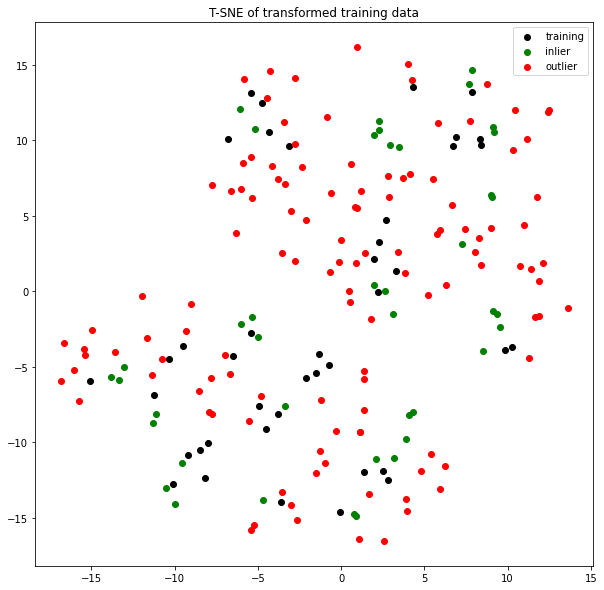

In [78]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np.vstack([S[:len(S_in)], S_in, S_out]))
X_embedded.shape

plt.rcParams["figure.figsize"] = (10, 10)
plt.scatter(X_embedded[:len(S_in), 0], X_embedded[:len(S_in), 1], c="black", label="training")
plt.scatter(X_embedded[len(S_in):len(S_in)+len(S_in), 0], X_embedded[len(S_in):len(S_in)+len(S_in), 1], c="green", label="inlier")
plt.scatter(X_embedded[len(S_in)+len(S_in):, 0], X_embedded[len(S_in)+len(S_in):, 1], c="red", label="outlier")
plt.legend()
plt.title("T-SNE of transformed training data")

In [ ]:
i = 3

plt.rcParams["figure.figsize"] = (10, 10)
plt.scatter(S_in[:, i], S_in[:, i+1], c="green", label="inlier")
plt.scatter(S_out[:, i], S_out[:, i+1], c="red", label="outlier")
plt.scatter(S[:len(S_in), i], S[:len(S_in), i+1], c="black", label="training")
plt.legend()

# Multimodal input

In [ ]:
bs = 50
augment = False
epochs = 1

clazz = 13
class_name = MVTEC.CLASSES[clazz]

X_, X_valid_, X_test_, X_labels_, T = zip(*[dataloader(clazz, P=224, s=224, label_per_patch=False, augment=augment) for i in range(epochs)])
X_, X_valid_, X_test_ = np.concatenate(X_), np.concatenate(X_valid_), np.concatenate(X_test_)
_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, augment=False)

net = mods.efficientnet_b4(pretrained=True).features[:6]
net = net.to(device)
net.eval()

X_, X_valid_, X_test_,  mean, std = preprocessing(X_, X_valid_, X_test_, None, None, None)

with torch.no_grad():
    X_ = torch.cat([ net(torch.from_numpy( X_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_), bs)]).cpu().numpy()
    X_valid_ = torch.cat([ net(torch.from_numpy( X_valid_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid_), bs)]).cpu().numpy()
    X_test_ = torch.cat([ net(torch.from_numpy( X_test_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test_), bs)]).cpu().numpy()

X_val_ = X_[:len(X_valid_)]
X_ = X_[len(X_valid_):]
c, fmap_h, fmap_w = X_.shape[1:]

In [ ]:
p = 8 # patch_size
s = 1 # stride tiles

# Transform images to patches
X_patches =       i2c(X_, p, stride=s)
X_valid_patches = i2c(X_valid_, p, stride=s)
X_test_patches =  i2c(X_test_, p, stride=s)
X_val_patches =   i2c(X_val_, p, stride=s)

# Compute initial cluster centers
init_cluster_centers = cluster_centers_tiles(X_, tile_size=p, stride=s)

# Dataset properties
n_features = X_patches.flatten() // len(X_patches)
n_tiles = len(X_patches) // len(X_)
n_clusters = len(init_cluster_centers)

# Clustering
kmeans = KMeans(n_clusters=n_clusters, init=init_cluster_centers, random_state=0, n_init=1).fit(flatten(X_patches))

# Cluster assignments
X_assignments = kmeans.predict(flatten(X_patches))
X_valid_assignments = kmeans.predict(flatten(X_valid_patches))
X_test_assignments = kmeans.predict(flatten(X_test_patches))
X_val_assignments = kmeans.predict(flatten(X_val_patches))

# Reset clusters
#X_assignments = np.tile(np.arange(n_tiles), len(X_))
#X_valid_assignments = np.tile(np.arange(n_tiles), len(X_valid_))
#X_test_assignments = np.tile(np.arange(n_tiles), len(X_test_))


# Visualization
plt.hist(X_assignments, label="X", alpha=0.5, bins=n_clusters)
plt.hist(X_test_assignments, label="Outliers", alpha=0.5, bins=n_clusters)
plt.hist(X_valid_assignments, label="Inliers", alpha=0.5, bins=n_clusters)
plt.title("Patch distribution across clusters")
plt.legend()

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np.vstack([init_cluster_centers, kmeans.cluster_centers_]))
X_embedded.shape

plt.scatter(X_embedded[:n_clusters, 0], X_embedded[:n_clusters, 1], c="black", label="initial")
plt.scatter(X_embedded[n_clusters:, 0], X_embedded[n_clusters:, 1], c="red", label="kmeans")
plt.legend()
plt.title("T-SNE of cluster centers")

In [ ]:
# Fitting PCA per cluster

models = []

class Transformer:
    
    def __init__(self, W, expl_var, mean, inverse=False, q=0.9999):
        
        # Takes only components that contribute above 90 percent, i.e, the least significant 10 %.
        explained_variance_ratio_ = expl_var/expl_var.sum()
        if inverse:
            mask = np.cumsum(explained_variance_ratio_) > q
        else:
            mask = np.cumsum(explained_variance_ratio_) < q
            
        n_components = mask.sum()
        self.A = W = W[mask] / np.sqrt( expl_var[mask] )[:, None]
        self.mean = mean
    
    def transform(self, X):
        return (X - self.mean) @ self.A.T

for i in range(n_clusters):
    model = PCA(n_components=0.9999, whiten=True)
    model.fit(X_patches[X_assignments == i])    
    model = Transformer(model.components_, model.explained_variance_, model.mean_)
    models.append(model)

n_clusters

In [ ]:
means_valid = []
means_test = []
mean_train = []
mean_val = []

def mean_shift_per_cluster(X, X_patches, X_assignments, m, i):
    n_tiles = len(X_assignments) // len(X)
    batch = np.repeat(np.arange(len(X)), n_tiles).astype(np.int32)[X_assignments == i] # [0,0,0,1,1,2,2..,] 
    idx_example, n_elements = np.unique(batch, return_counts=True)
    Z = m.transform(X_patches[X_assignments == i])
    
    Z_mean = np.zeros((len(X), Z.shape[1] )) # n_datapoints, n_features
    np.add.at(Z_mean, batch, Z)
    Z_mean[idx_example] = Z_mean[idx_example] / n_elements[:, None]
    return Z_mean

for i,m in enumerate(models):
    Z_mean = mean_shift_per_cluster(X_, X_patches, X_assignments, m, i)
    mean_train.append(Z_mean)
    
    Z_val_mean = mean_shift_per_cluster(X_val_, X_val_patches, X_val_assignments, m, i)
    mean_val.append(Z_val_mean)
    
    Z_valid_mean = mean_shift_per_cluster(X_valid_, X_valid_patches, X_valid_assignments, m, i)
    means_valid.append(Z_valid_mean)
    
    Z_test_mean = mean_shift_per_cluster(X_test_, X_test_patches, X_test_assignments, m, i)
    means_test.append(Z_test_mean)     

#for i in range(n_clusters):
#    means_valid[i] = np.linalg.norm(means_valid[i], axis=1)
#    means_test[i] = np.linalg.norm(means_test[i], axis=1) 
#scores_valid = np.stack(means_valid).sum(0)
#scores_test = np.stack(means_test).sum(0)

mean_val = np.hstack(mean_val)
mean_train = np.hstack(mean_train)
means_valid = np.hstack(means_valid)
means_test = np.hstack(means_test)
scores_valid = np.linalg.norm(means_valid, axis=1)
scores_test = np.linalg.norm(means_test, axis=1)

auc1 = roc_auc_score([0] * len(scores_valid) + [1] * len(scores_test), np.concatenate([scores_valid, scores_test]))        
print("Total AUC", auc1)

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np.vstack([mean_val, means_valid, means_test]))
X_embedded.shape

plt.scatter(X_embedded[:len(mean_val), 0], X_embedded[:len(mean_val), 1], c="black", label="valid")
plt.scatter(X_embedded[len(mean_val):len(mean_val)+len(means_valid), 0], X_embedded[len(mean_val):len(mean_val)+len(means_valid), 1], c="green", label="inlier")
plt.scatter(X_embedded[len(mean_val)+len(means_valid):, 0], X_embedded[len(mean_val)+len(means_valid):, 1], c="red", label="outlier")
plt.legend()
plt.title("T-SNE of transformed training data")

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np.vstack([mean_train, means_valid, means_test]))
X_embedded.shape

plt.scatter(X_embedded[:len(mean_train), 0], X_embedded[:len(mean_train), 1], c="black", label="training")
plt.scatter(X_embedded[len(mean_train):len(mean_train)+len(means_valid), 0], X_embedded[len(mean_train):len(mean_train)+len(means_valid), 1], c="green", label="inlier")
plt.scatter(X_embedded[len(mean_train)+len(means_valid):, 0], X_embedded[len(mean_train)+len(means_valid):, 1], c="red", label="outlier")
plt.legend()
plt.title("T-SNE of transformed training data")

In [ ]:
plt.bar(range(means_valid.shape[1]), means_valid.mean(0))
plt.bar(range(means_test.shape[1]), means_test.mean(0))

# Multimodal sources

In [ ]:
net = mods.efficientnet_b4(pretrained=True).features[:6]
net = net.to(device)
net = net.eval()

In [ ]:
def preprocessing(X, In, Out, a, b, c):
    
    # DC
    #X, In, Out = (X - X.mean((1,2,3), keepdims=True), 
    #               In - In.mean((1,2,3), keepdims=True), 
    #                Out - Out.mean((1,2,3), keepdims=True))
    
    # Contrast
    #X, In, Out = (X / np.linalg.norm(X.reshape(len(X), -1), axis=1, keepdims=True)[:, :, None, None], 
    #              In / np.linalg.norm(In.reshape(len(In), -1), axis=1, keepdims=True)[:, :, None, None], 
    #              Out / np.linalg.norm(Out.reshape(len(Out), -1), axis=1, keepdims=True)[:, :, None, None])

    # Rescale
    scale = X.std()
    X = X / scale
    In = In / scale
    Out = Out / scale    
    
    return X, In, Out, 0, 0 #scale


In [ ]:
bs = 50
augment = True
epochs = 1

clazz = 13
class_name = MVTEC.CLASSES[clazz]

X_, X_valid_, X_test_, X_labels_, T = zip(*[dataloader(clazz, P=224, s=224, label_per_patch=False, augment=augment) for i in range(epochs)])
X_, X_valid_, X_test_ = np.concatenate(X_), np.concatenate(X_valid_), np.concatenate(X_test_)
X_val_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, augment=False)
X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, augment=False)

X_, X_valid_, X_test_,  mean, std = preprocessing(X_, X_valid_, X_test_, None, None, None)

X_val_ = X_[:int(len(X_)*0.2)]
X_ = X_[int(len(X_)*0.2):]

with torch.no_grad():
    X_ = torch.cat([ net(torch.from_numpy( X_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_), bs)]).cpu().numpy()
    X_val_ = torch.cat([ net(torch.from_numpy( X_val_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_val_), bs)]).cpu().numpy()
    X_valid_ = torch.cat([ net(torch.from_numpy( X_valid_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid_), bs)]).cpu().numpy()
    X_test_ = torch.cat([ net(torch.from_numpy( X_test_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test_), bs)]).cpu().numpy()

n, n_val, n_in, n_out, c = len(X_), len(X_val_), len(X_valid_), len(X_test_), X_.shape[1]
n, n_val, n_in, n_out, T
    
c, fmap_h, fmap_w = X_.shape[1:]
c, fmap_h, fmap_w

In [ ]:
for bsz in [3]:
    model = SFA(shape=(c, fmap_h, fmap_w), 
                   BSZ=(bsz, bsz), 
                   stride=1, 
                   n_components="q10",
                   mode="ta")
    model.fit(X_, 1, bs=2500, logging=-1)

In [ ]:
S = model.transform(np.asarray(X_), agg="mean")
S_val = model.transform(np.asarray(X_val_), agg="mean")
S_in = model.transform(np.asarray(X_valid_), agg="mean")
S_out = model.transform(np.asarray(X_test_), agg="mean")
S_out.shape, S_in.shape, S_val.shape

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np.vstack([S_val, S_in, S_out]))
X_embedded.shape

plt.scatter(X_embedded[:len(S_val), 0], X_embedded[:len(S_val), 1], c="black", label="training")
plt.scatter(X_embedded[len(S_val):len(S_val)+len(S_in), 0], X_embedded[len(S_val):len(S_val)+len(S_in), 1], c="green", label="inlier")
plt.scatter(X_embedded[len(S_val)+len(S_in):, 0], X_embedded[len(S_val)+len(S_in):, 1], c="red", label="outlier")
plt.legend()
plt.title("T-SNE of transformed training data")

In [ ]:
i = 3
plt.scatter(S_in[:, i], S_in[:, i+1], c="green", label="inlier")
plt.scatter(S_out[:, i], S_out[:, i+1], c="red", label="outlier")
plt.scatter(S_val[:, i], S_val[:, i+1], c="black", label="training")

# T-SNE to show multimodality

In [ ]:
from sklearn.manifold import TSNE

net = mods.efficientnet_b4(pretrained=True).features[:6]
net = net.to(device)
net.eval()

In [ ]:
bs = 14
clazz = 13
augment = True
epochs = 3
p = 224
s = 112

X_, X_valid_, X_test_, X_labels_, T = zip(*[dataloader(clazz, P=p, s=s, label_per_patch=False, augment=augment) for i in range(epochs)])
X_, X_valid_, X_test_ = np.concatenate(X_), np.concatenate(X_valid_), np.concatenate(X_test_)

_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=p, s=s, label_per_patch=False, augment=False)

with torch.no_grad():
    X_ = torch.cat([ net(torch.from_numpy( X_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_), bs)]).cpu().numpy()
    X_valid_ = torch.cat([ net(torch.from_numpy( X_valid_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid_), bs)]).cpu().numpy()
    X_test_ = torch.cat([ net(torch.from_numpy( X_test_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test_), bs)]).cpu().numpy()

X_val_ = X_[:int(len(X_)*0.5)]
X_ = X_[int(len(X_)*0.5):]

n, n_val, n_in, n_out, c = len(X_), len(X_val_), len(X_valid_), len(X_test_), X_.shape[1]
n, n_val, n_in, n_out, T

In [ ]:
X__ = X_.transpose(0,2,3,1).mean((1,2)).reshape(-1, c) 
X_val__ = X_val_.transpose(0,2,3,1).mean((1,2)).reshape(-1, c) 
X_valid__ = X_valid_.transpose(0,2,3,1).mean((1,2)).reshape(-1, c) 
X_test__ = X_test_.transpose(0,2,3,1).mean((1,2)).reshape(-1, c) 

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np.vstack([X_val__, X_valid__, X_test__]))
X_embedded.shape

plt.scatter(X_embedded[:n_val, 0], X_embedded[:n_val, 1], c="black", label="validation")
plt.scatter(X_embedded[n_val:n_val+n_in, 0], X_embedded[n_val:n_val+n_in, 1], c="green", label="inlier")
plt.scatter(X_embedded[n_val+n_in:, 0], X_embedded[n_val+n_in:, 1], c="red", label="outlier")
plt.legend()

In [ ]:
X__ = flatten(X_) 
X_val__ = flatten(X_val_) 
X_valid__ = flatten(X_valid_) 
X_test__ = flatten(X_test_) 

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np.vstack([X_val__, X_valid__, X_test__]))
X_embedded.shape

plt.scatter(X_embedded[:n_val, 0], X_embedded[:n_val, 1], c="black", label="validation")
plt.scatter(X_embedded[n_val:n_val+n_in, 0], X_embedded[n_val:n_val+n_in, 1], c="green", label="inlier")
plt.scatter(X_embedded[n_val+n_in:, 0], X_embedded[n_val+n_in:, 1], c="red", label="outlier")
plt.legend()

In [ ]:
bs = 14
clazz = 13

X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False)

net = models.efficientnet_b4(pretrained=True).features[:6]
net = net.to(device)
net.eval()

with torch.no_grad():
    X_ = torch.cat([ net(torch.from_numpy( X_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_), bs)]).cpu().numpy()
    X_valid_ = torch.cat([ net(torch.from_numpy( X_valid_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid_), bs)]).cpu().numpy()
    X_test_ = torch.cat([ net(torch.from_numpy( X_test_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test_), bs)]).cpu().numpy()

X_val_ = X_[:int(len(X_)*0.3)]

n_val, n_in, n_out = len(X_val_), len(X_valid_), len(X_test_)

In [ ]:
c = X_test_.shape[1]
X_test_.shape, n_val, n_in, n_out 

## pooling

In [ ]:
X__ = X_.transpose(0,2,3,1).mean((1,2)).reshape(-1, c) 
X_val__ = X_val_.transpose(0,2,3,1).mean((1,2)).reshape(-1, c) 
X_valid__ = X_valid_.transpose(0,2,3,1).mean((1,2)).reshape(-1, c) 
X_test__ = X_test_.transpose(0,2,3,1).mean((1,2)).reshape(-1, c) 

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np.vstack([X_val__, X_valid__, X_test__]))
X_embedded.shape

In [ ]:
plt.scatter(X_embedded[:n_val, 0], X_embedded[:n_val, 1], c="black", label="validation")
plt.scatter(X_embedded[n_val:n_val+n_in, 0], X_embedded[n_val:n_val+n_in, 1], c="green", label="inlier")
plt.scatter(X_embedded[n_val+n_in:, 0], X_embedded[n_val+n_in:, 1], c="red", label="outlier")
plt.legend()

## patches

In [ ]:
t = 1

X__ = X_.transpose(0,2,3,1).reshape(-1, c) 
X_val__ = X_val_.transpose(0,2,3,1).reshape(-1, c) 
X_valid__ = X_valid_.transpose(0,2,3,1).reshape(-1, c)
X_test__ = X_test_.transpose(0,2,3,1).reshape(-1, c)[:len(X_valid__)]
X_valid__.shape, X_test__.shape, X_val__.shape
n_val, n_in, n_out = len(X_val__), len(X_valid__), len(X_test__)
n_val, n_in, n_out

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np.vstack([X_val__, X_valid__, X_test__]))
X_embedded.shape

In [ ]:
plt.scatter(X_embedded[n_val+n_in:, 0], X_embedded[n_val+n_in:, 1], c="red", label="outlier")
plt.scatter(X_embedded[:n_val, 0], X_embedded[:n_val, 1], c="black", label="validation")
plt.scatter(X_embedded[n_val:n_val+n_in, 0], X_embedded[n_val:n_val+n_in, 1], c="green", label="inlier")
plt.legend()

In [ ]:
t = 4 # tile_size
n_tiles = 3
s = 1

inliers = []
outliers = []
vals = []

for i in range(n_tiles):
    for j in range(n_tiles):

        X_vals = X_val_[:, :, i*s:(i+1)*s+t, j*s:(j+1)*s+t]
        X_in = X_valid_[:, :, i*s:(i+1)*s+t, j*s:(j+1)*s+t]
        X_out = X_test_[:, :, i*s:(i+1)*s+t, j*s:(j+1)*s+t]
        
        inliers.append(X_in)
        outliers.append(X_out)
        vals.append(X_vals)

X_valid__ = np.concatenate(inliers) 
X_test__ = np.concatenate(outliers) 
X_val__ = np.concatenate(vals) 


X_valid__ = X_valid__.transpose(0,2,3,1).sum((1,2)).reshape(-1, c)
X_test__ = X_test__.transpose(0,2,3,1).sum((1,2)).reshape(-1, c)[:len(X_valid__)]
X_val__ = X_val__.transpose(0,2,3,1).sum((1,2)).reshape(-1, c)
n_val, n_in, n_out = len(X_val__), len(X_valid__), len(X_test__)

from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np.vstack([X_val__, X_valid__, X_test__]))
X_embedded.shape

plt.scatter(X_embedded[n_val+n_in:, 0], X_embedded[n_val+n_in:, 1], c="red", label="outlier")
plt.scatter(X_embedded[:n_val, 0], X_embedded[:n_val, 1], c="black", label="validation")
plt.scatter(X_embedded[n_val:n_val+n_in, 0], X_embedded[n_val:n_val+n_in, 1], c="green", label="inlier")
plt.legend()

In [ ]:
t = 4 # tile_size
n_tiles = 3

inliers = []
outliers = []
vals = []

for i in range(n_tiles):
    for j in range(n_tiles):

        X_vals = X_val_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
        X_in = X_valid_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
        X_out = X_test_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
        
        inliers.append(X_in)
        outliers.append(X_out)
        vals.append(X_vals)
X_valid__ = np.concatenate(inliers) 
X_test__ = np.concatenate(outliers) 
X_val__ = np.concatenate(vals) 


X_valid__ = X_valid__.transpose(0,2,3,1).sum((1,2)).reshape(-1, c)
X_test__ = X_test__.transpose(0,2,3,1).sum((1,2)).reshape(-1, c)[:len(X_valid__)]
X_val__ = X_val__.transpose(0,2,3,1).sum((1,2)).reshape(-1, c)
n_val, n_in, n_out = len(X_val__), len(X_valid__), len(X_test__)

from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np.vstack([X_val__, X_valid__, X_test__]))
X_embedded.shape

plt.scatter(X_embedded[n_val+n_in:, 0], X_embedded[n_val+n_in:, 1], c="red", label="outlier")
plt.scatter(X_embedded[:n_val, 0], X_embedded[:n_val, 1], c="black", label="validation")
plt.scatter(X_embedded[n_val:n_val+n_in, 0], X_embedded[n_val:n_val+n_in, 1], c="green", label="inlier")
plt.legend()

In [ ]:
t = 3 # tile_size
n_tiles = 2

inliers = []
outliers = []
vals = []

for i in range(n_tiles):
    for j in range(n_tiles):

        X_vals = X_val_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
        X_in = X_valid_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
        X_out = X_test_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
        
        inliers.append(X_in)
        outliers.append(X_out)
        vals.append(X_vals)
X_valid__ = np.concatenate(inliers) 
X_test__ = np.concatenate(outliers) 
X_val__ = np.concatenate(vals) 


X_valid__ = X_valid__.transpose(0,2,3,1).sum((1,2)).reshape(-1, c)
X_test__ = X_test__.transpose(0,2,3,1).sum((1,2)).reshape(-1, c)[:len(X_valid__)]
X_val__ = X_val__.transpose(0,2,3,1).sum((1,2)).reshape(-1, c)
n_val, n_in, n_out = len(X_val__), len(X_valid__), len(X_test__)

from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np.vstack([X_val__, X_valid__, X_test__]))
X_embedded.shape

plt.scatter(X_embedded[n_val+n_in:, 0], X_embedded[n_val+n_in:, 1], c="red", label="outlier")
plt.scatter(X_embedded[:n_val, 0], X_embedded[:n_val, 1], c="black", label="validation")
plt.scatter(X_embedded[n_val:n_val+n_in, 0], X_embedded[n_val:n_val+n_in, 1], c="green", label="inlier")
plt.legend()

In [ ]:
t = 2 # tile_size
n_tiles = 3

inliers = []
outliers = []
vals = []

for i in range(n_tiles):
    for j in range(n_tiles):

        X_vals = X_val_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
        X_in = X_valid_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
        X_out = X_test_[:, :, i*t:(i+1)*t, j*t:(j+1)*t]
        
        inliers.append(X_in)
        outliers.append(X_out)
        vals.append(X_vals)
X_valid__ = np.concatenate(inliers) 
X_test__ = np.concatenate(outliers) 
X_val__ = np.concatenate(vals) 


X_valid__ = X_valid__.transpose(0,2,3,1).sum((1,2)).reshape(-1, c)
X_test__ = X_test__.transpose(0,2,3,1).sum((1,2)).reshape(-1, c)[:len(X_valid__)]
X_val__ = X_val__.transpose(0,2,3,1).sum((1,2)).reshape(-1, c)
n_val, n_in, n_out = len(X_val__), len(X_valid__), len(X_test__)


from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np.vstack([X_val__, X_valid__, X_test__]))
X_embedded.shape

plt.scatter(X_embedded[n_val+n_in:, 0], X_embedded[n_val+n_in:, 1], c="red", label="outlier")
plt.scatter(X_embedded[:n_val, 0], X_embedded[:n_val, 1], c="black", label="validation")
plt.scatter(X_embedded[n_val:n_val+n_in, 0], X_embedded[n_val:n_val+n_in, 1], c="green", label="inlier")
plt.legend()

# flatten

In [ ]:
X__ = X_.reshape(len(X_), -1)
X_val__ = X_val_.reshape(len(X_val_), -1)
X_valid__ = X_valid_.reshape(len(X_valid_), -1)
X_test__ = X_test_.reshape(len(X_test_),-1)[:len(X_valid__)]
n_val, n_in, n_out = len(X_val__), len(X_valid__), len(X_test__)


In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np.vstack([X_val__, X_valid__, X_test__]))
X_embedded.shape

In [ ]:
plt.scatter(X_embedded[:n_val, 0], X_embedded[:n_val, 1], c="black", label="validation")
plt.scatter(X_embedded[n_val:n_val+n_in, 0], X_embedded[n_val:n_val+n_in, 1], c="green", label="inlier")
plt.scatter(X_embedded[n_val+n_in:, 0], X_embedded[n_val+n_in:, 1], c="red", label="outlier")
plt.legend()

# dimension reduction

In [ ]:
X__ = X_.reshape(len(X_), -1)
X_val__ = X_val_.reshape(len(X_val_), -1)
X_valid__ = X_valid_.reshape(len(X_valid_), -1)
X_test__ = X_test_.reshape(len(X_test_),-1)[:len(X_valid__)]
n_val, n_in, n_out = len(X_val__), len(X_valid__), len(X_test__)

pca = PCA(n_components=0.9, whiten=False).fit(X__)
X_val__ = pca.transform(X_val__)
X_valid__ = pca.transform(X_valid__)
X_test__ = pca.transform(X_test__)

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np.vstack([X_val__, X_valid__, X_test__]))
X_embedded.shape
plt.scatter(X_embedded[:n_val, 0], X_embedded[:n_val, 1], c="black", label="validation")
plt.scatter(X_embedded[n_val:n_val+n_in, 0], X_embedded[n_val:n_val+n_in, 1], c="green", label="inlier")
plt.scatter(X_embedded[n_val+n_in:, 0], X_embedded[n_val+n_in:, 1], c="red", label="outlier")
plt.legend()